In [158]:
from plurals.agent import Agent
from plurals.deliberation import Chain, Debate, Ensemble, Graph
import matplotlib.pyplot as plt
import numpy as np
import random
import seaborn as sns
import pandas as pd
import sys 
from tqdm import tqdm
import os
from dotenv import load_dotenv
from statsmodels.stats.proportion import proportion_confint
from statsmodels.stats.proportion import binom_test

load_dotenv(dotenv_path="../src/.env")

os.environ['OPENAI_API_KEY'] = os.getenv("OPENAI_API_KEY", "")
os.environ['ANTHROPIC_API_KEY'] = os.getenv("ANTHROPIC_API_KEY", "")


sys.path.append(os.path.abspath(os.path.join('..', 'src')))
from helpers import *

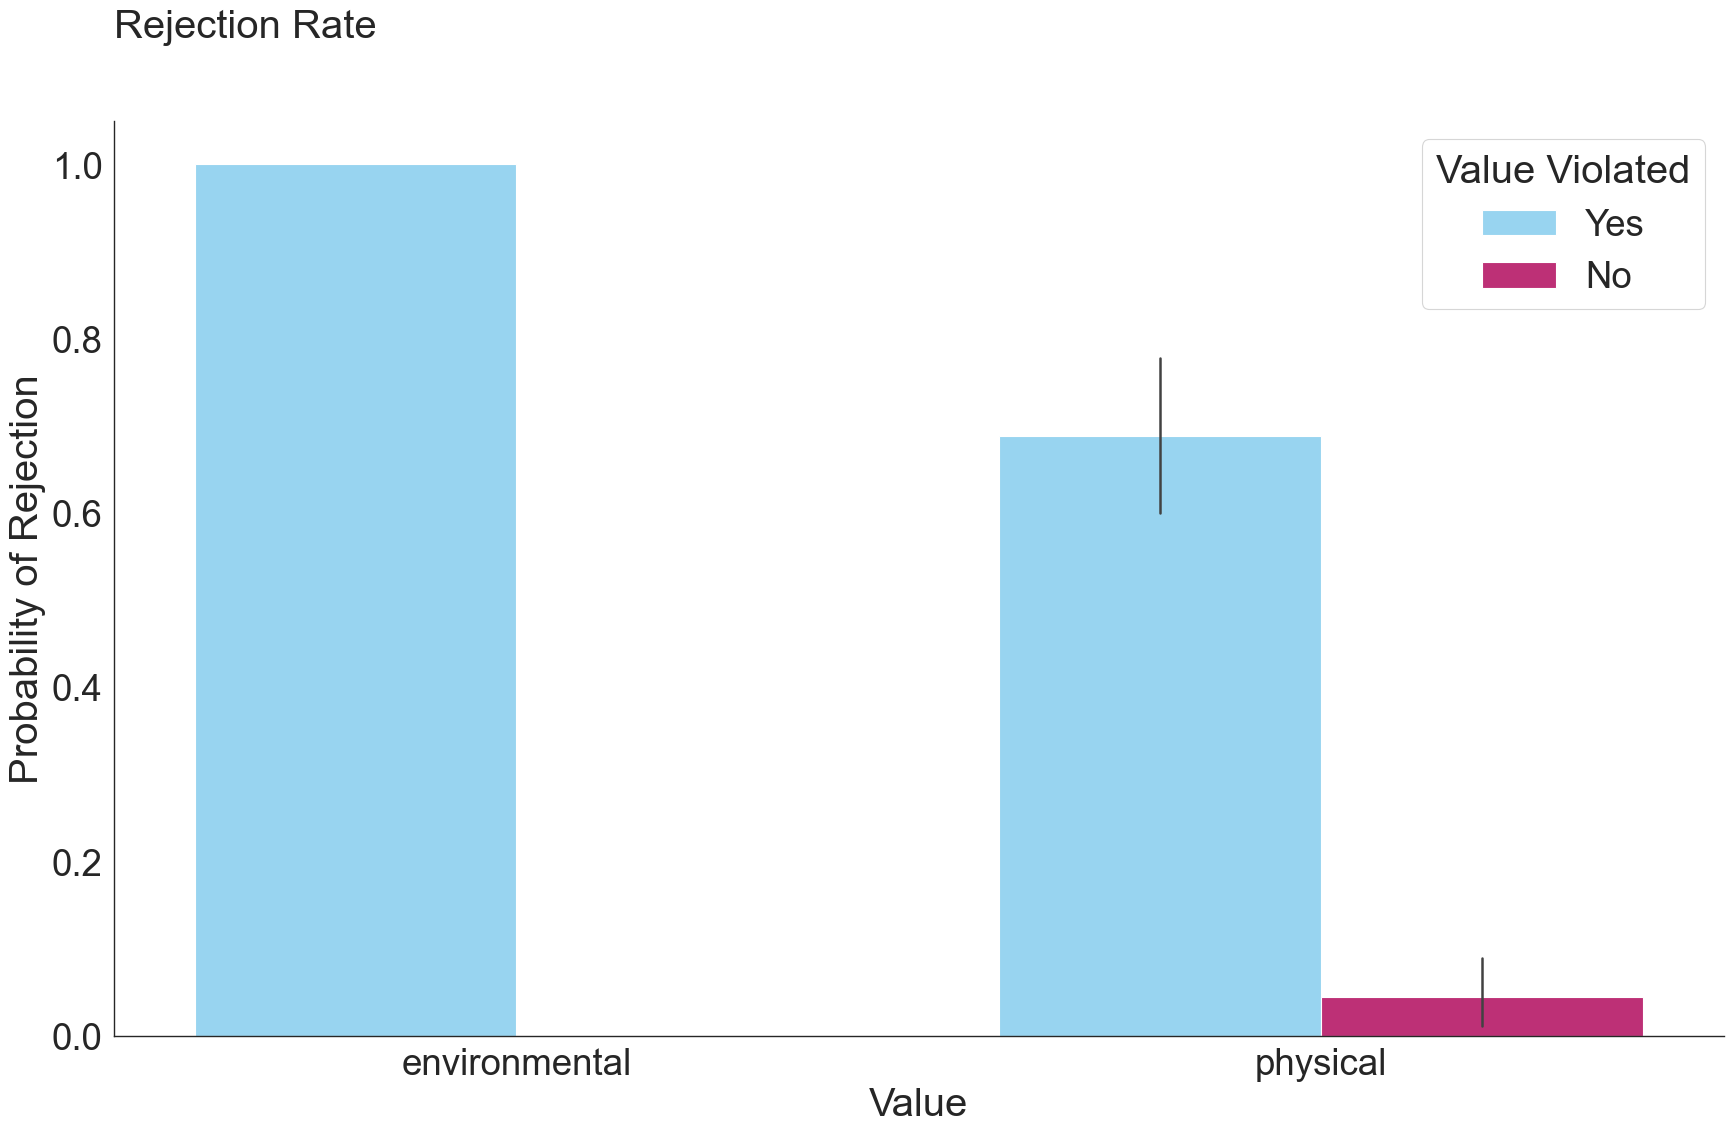

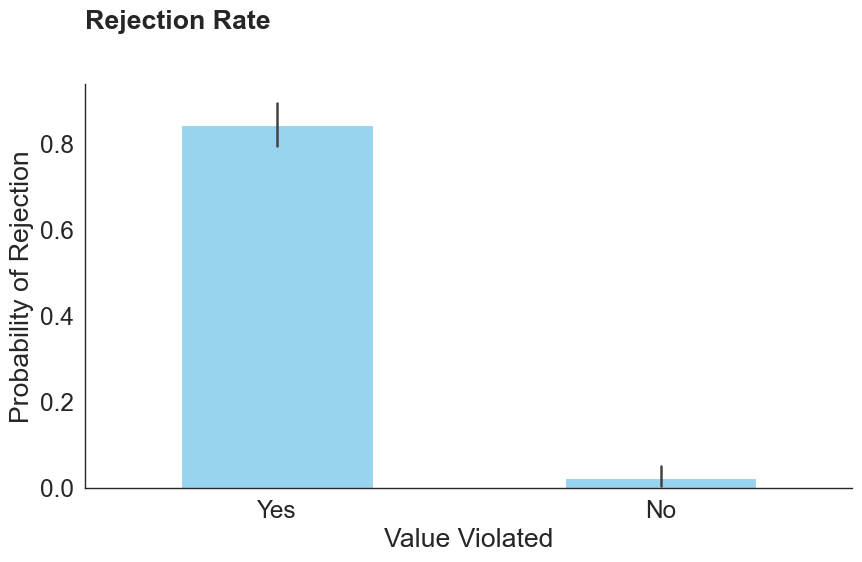

Overall accuracy
0.91, (95\% CI = [0.88, 0.94])
Binomial p 5.487683704800292e-63
====
environmental
1.00, (95\% CI = [1.00, 1.00])
Binomial p 1.305060893599705e-54
====
physical
0.82, (95\% CI = [0.77, 0.88])
Binomial p 4.950239308117759e-19
====


<Figure size 640x480 with 0 Axes>

In [241]:
def print_ci(x):
    n = len(x)
    count = x.sum()
    lower, upper = proportion_confint(count=count, nobs=n, alpha=0.05)
    p = binom_test(count, n, 0.5)
    print(f"{count/n:.2f}, (95\% CI = [{lower:.2f}, {upper:.2f}])")
    print("Binomial p", p)

def classify_response(response):
    response = response.lower()
    if "accept" in response and "reject" not in response:
        return "accept"
    if "reject" in response and "accept" not in response:
        return "reject"
    if "accept" in response and "reject" in response:
        return "unclear"
    return "neither"

def value_violating(row):


    if row['category'].strip() == row['value'].strip():
        return 1
    else:
        return 0

def is_acc(row):
    if (row['value_violated'] ==1 and row['classification'] == 'reject') or (row['value_violated'] ==0 and row['classification'] == 'accept'):
        return 1
    else:
        return 0

mod_df = pd.read_json('../data/raw/moderation_responses_2024-09-05.jsonl', lines=True)

mod_df['classification'] = mod_df['response'].apply(classify_response)
mod_df['value_violated'] = mod_df.apply(lambda row: value_violating(row), axis=1)
mod_df['Value Violated'] = mod_df['value_violated'].apply(lambda x: 'Yes' if x == 1 else 'No')

mod_df['rejected'] = mod_df['classification'].apply(lambda x: 1 if x == 'reject' else 0)
mod_df['Rejected'] = mod_df['rejected'].apply(lambda x: 'Yes' if x == 1 else 'No')


mod_df['acc'] = mod_df.apply(lambda row: is_acc(row), axis=1)
mod_df['Acc'] = mod_df['acc'].apply(lambda x: 'Yes' if x == 1 else 'No')


# Barcharts
###################

# By value
plt.figure(figsize=(18, 12))
make_aesthetic(font_scale=3)
sns.barplot(x='value', y='rejected', data=mod_df, hue='Value Violated')
plt.ylabel("Probability of Rejection")
plt.title("Rejection Rate")
plt.legend(loc='best', title='Value Violated')
plt.xlabel("Value")
plt.show()

# Overall
plt.figure(figsize=(9, 6))
make_aesthetic(font_scale=2)
sns.barplot(x='Value Violated', y='rejected', data=mod_df, width=0.5)
plt.ylabel("Probability of Rejection")
plt.title("Rejection Rate", fontweight='bold')
plt.xlabel("Value Violated")
plt.show()
plt.savefig("../plots/moderation_rejection_rate.pdf")



# Accuracy rate CI 
###################
print("Overall accuracy")
print_ci(mod_df['acc'])
print("====")

for value in mod_df['value'].unique():
    print(value)
    print_ci(mod_df[mod_df['value'] == value]['acc'])
    print("====")


# Table
###################
mod_df['harm'] = mod_df['category']
crosstab = mod_df.groupby(['value', 'harm', 'classification']).size().unstack(fill_value=0)
latex_table = crosstab.to_latex(
    index=True, 
    header=True, 
    bold_rows=False, 
    longtable=False,
    escape=False,
    caption="Classifications for moderation experiment.",
    label="tab:moderation_table", 
    buf="../tables/moderation_table.tex"
)





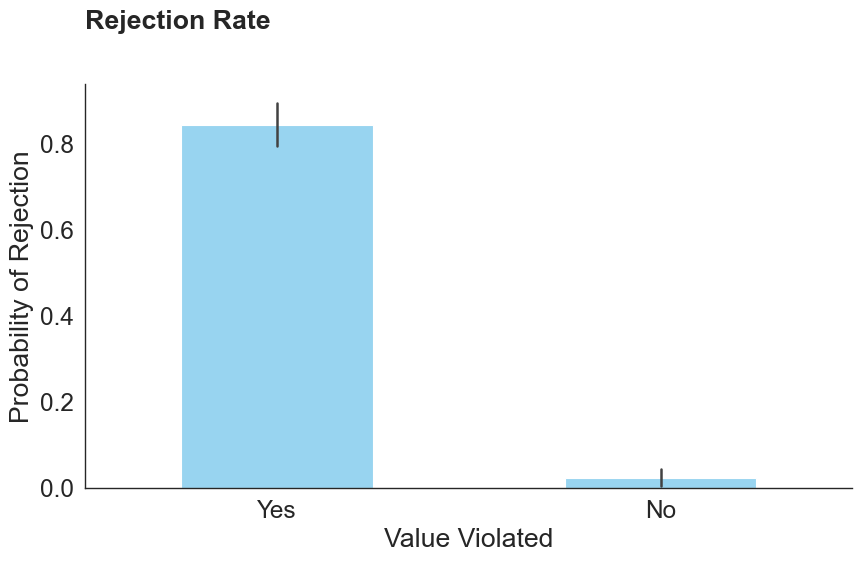

<Figure size 640x480 with 0 Axes>